# BioscrapeCOBRA: a hyrid composite of chemical reaction networks with flux balance analysis

## Overview
This notebook combines a chemical reaction network model with a flux balance analysis model, and a physics engine

* SBML
* BiGG model

In [1]:
#@title install vivarium libraries

#Uncomment in Colab Below

"""
%%capture
!pip install git+https://github.com/vivarium-collective/vivarium-notebooks
!pip install vivarium-core==0.1.5
!pip install vivarium-cobra==0.0.6
!pip install vivarium-pymunk==0.0.2
!pip install vivarium-bioscrape
"""

# assert correct library versions are loaded
from importlib.metadata import version
assert version('vivarium-core') == '0.1.10'
assert version('vivarium-cobra') == '0.0.7'
assert version('vivarium-bioscrape') == '0.0.0.4'
assert version('vivarium-multibody') == '0.0.4'

In [2]:
#@title imports
import numpy as np
import pylab as plt

# process/composition interface
from vivarium.core.process import (
    Process, Deriver, Composite,
)

# helper functions for composition
from vivarium.core.composition import (
    simulate_process_in_experiment,
    simulate_compartment_in_experiment,
    compartment_in_experiment,
    compose_experiment,
    FACTORY_KEY,
)

# other vivarium imports
from vivarium.core.experiment import Experiment, pp
from vivarium.library.units import units

# vivarium plotting functions
from vivarium.plots.simulation_output import (
    plot_simulation_output, plot_variables, save_fig_to_dir)
from vivarium.plots.agents_multigen import plot_agents_multigen
from vivarium.plots.topology import plot_topology

# import processes and composites
from vivarium.processes.tree_mass import TreeMass
from vivarium.processes.divide_condition import DivideCondition
from vivarium.processes.meta_division import MetaDivision

# vivarium-cobra processes
from vivarium_cobra.processes.volume import Volume
from vivarium_cobra.composites.cobra_composite import CobraComposite
from vivarium_cobra.processes.dynamic_fba import (
    DynamicFBA, 
    get_iAF1260b_config, 
    print_growth
)

# vivarium-bioscrape processes
from vivarium_bioscrape.processes.bioscrape import Bioscrape


# Multi-paradigm composites

Vivarium is a powerful tool for combining previously-isolated frameworks in computational biology.
This section combines flux balance analysis (FBA), chemical reaction networks (CRNs), and a physics engine, to simulate many individual cells in a spatial environment.

## **Paradigm 1**: Flux Balance Analysis with COBRA

[Constraint-based reconstruction and analysis (COBRA)](https://cobrapy.readthedocs.io/en/latest/) is a popular FBA solver.

The [vivarium-cobra library](https://github.com/vivarium-collective/vivarium-cobra) provides a Vivarium wrapper process for COBRA:
 ```
 pip install vivarium-cobra
 ```
 
### BIGG models
* The COBRA process can load [BiGG metabolic models](http://bigg.ucsd.edu) -- over 100 models are available, including dozens of *E. coli* strains. 
* Here, *iAF1260b* is load, which has 2382 reactions, 1261 genes, and 166 metabolites.
* The objective function, with 67 molecules, is stored in internal pools. There are 299 external molecules -- of these, 19 show dynamics in minimal glucose conditions.

In [3]:
def plot_metabolism(data):

    ncol = 2

    original_fontsize = plt.rcParams['font.size']
    plt.rcParams.update({'font.size': 9})

    # initialize subplots
    n_rows = 3
    n_cols = 1
    fig = plt.figure(figsize=(n_cols * 10, n_rows * 2))
    grid = plt.GridSpec(n_rows, n_cols)

    time_vec = data['time']

    # external
    ax = fig.add_subplot(grid[0, 0])
    for mol_id, series in data['external'].items():
        if sum(series) != 0.0:
            ax.plot(time_vec, series, label=mol_id)
    ax.set_title('external concentrations (log)')
    ax.set_yscale('log')
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(bottom=False, labelbottom=False)
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=ncol)

    # internal
    ax = fig.add_subplot(grid[1, 0])
    for mol_id, series in data['internal_counts'].items():
        if sum(series) != 0.0:
            ax.plot(time_vec, series, label=mol_id)
    ax.set_title('internal molecule counts (log)')
    ax.set_xlabel('time (sec)')
    ax.set_yscale('log')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(bottom=False, labelbottom=False)

    
    # mass
    ax = fig.add_subplot(grid[2, 0])
    ax.plot(time_vec, data['global'][('mass', 'femtogram')], label='mass')
    ax.set_title('total compartment mass (fg)')
    ax.set_xlabel('time (sec)')
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)  
    
    fig.tight_layout()
    
    
    return fig

In [4]:
compartment_in_experiment
# get the configuration for the iAF1260b BiGG model
cobra_config = get_iAF1260b_config()
cobra_config.update({'time_step': 10})
config = {'cobra': cobra_config}   

# load it into DynamicFBA
metabolism = CobraComposite(config)

# get the model's initial state
initial_state = metabolism.initial_state({}) 

# run simulation
sim_settings = {
    'initial_state': initial_state,
    'total_time': 500}
cobra_timeseries = simulate_compartment_in_experiment(metabolism, sim_settings)


Experiment ID: ebb0bca0-670c-11eb-8fe3-acde48001122
Created: 02/04/2021 at 09:17:55
Completed in 6.23 seconds


volume growth: 1.1433345369510877
mass growth: 1.1433345369510879


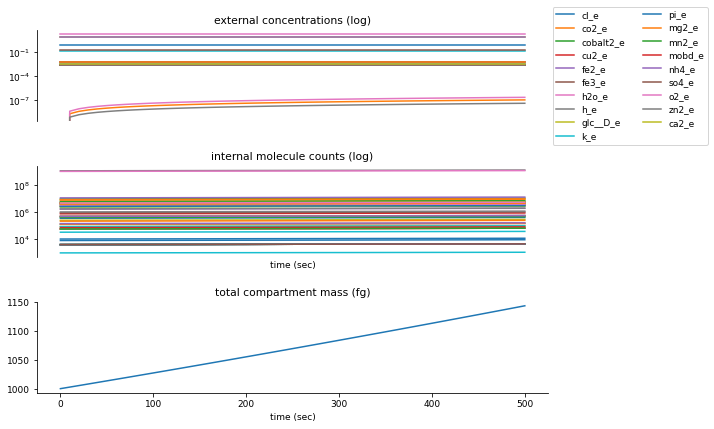

In [5]:
print_growth(cobra_timeseries['global'])
fig = plot_metabolism(cobra_timeseries)

## **Paradigm 2**: Chemical Reaction Network with Bioscrape

Bioscrape is an easily extensible and modular object-oriented framework for building and simulating CRNs. Bioscrape Process loads Systems Biology Markup Language (SBML) files.

The [vivarium-bioscrape library](https://github.com/vivarium-collective/vivarium-bioscrape) provides a Vivarium wrapper process for Bioscrape:
 ```
 pip install vivarium-bioscrape
 ```

In [6]:
# initialize Bioscrape process
time_step = 10

#This will configure a deterministic model as a system of ODEs
deterministic_bioscrape_config = {
            'sbml_file': 'LacOperon_deterministic.xml',
            'stochastic': False,
            'initial_volume': 1,
            'internal_dt': 0.01,
            'time_step':time_step}


bioscrape_process_deterministic = Bioscrape(deterministic_bioscrape_config)

In [7]:
#Run the simulation
total_time = 10000

# initial state
initial_state = bioscrape_process_deterministic.initial_state()

# run simulation
settings = {
    'total_time': total_time,
    'initial_state': initial_state,
    'display_info': False,
    'progress_bar': False}
bioscrape_timeseries_deterministic = simulate_process_in_experiment(bioscrape_process_deterministic, settings)


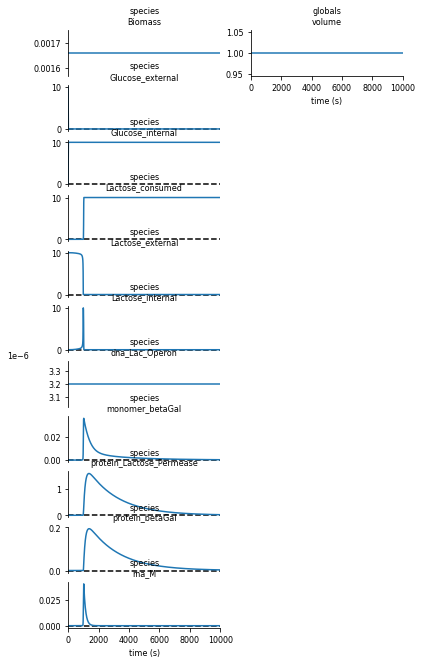

In [8]:
fig = plot_simulation_output(bioscrape_timeseries_deterministic)

In [9]:
#This will configure a stochastic model using the Gillespie SSA algorithm
stochastic_bioscrape_config = {
            'sbml_file': 'LacOperon_stochastic.xml',
            'stochastic': True,
            'safe_mode':True,
            'initial_volume': 1,
            'internal_dt': 0.1,
            'time_step':time_step}

bioscrape_process_stochastic = Bioscrape(stochastic_bioscrape_config)

In [10]:
#Run the simulation
total_time = 10000

# initial state
initial_state = bioscrape_process_stochastic.initial_state()
print(initial_state)

# run simulation
settings = {
    'total_time': total_time,
    'initial_state': initial_state,
    'display_info': False,
    'progress_bar': False}
bioscrape_timeseries_stochastic = simulate_process_in_experiment(bioscrape_process_stochastic, settings)

print("Complete!")

{'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 500000.0, 'Lactose_internal': 0.0, 'Glucose_external': 500000.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}}
states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 500000.0, 'Lactose_internal': 0.0, 'Glucose_external': 500000.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 500000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0, 

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 500000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0, 

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 500000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0, 

took 0.003736999999997437
states {'species': {'rna_M': 0.0, 'monomer_betaGal': 3.0, 'protein_betaGal': 0.0, 'Lactose_external': 425782.0, 'Lactose_internal': 74218.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 7.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -1800.0, 'Lactose_internal': 1800.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.

took 0.009069000000000216
states {'species': {'rna_M': 1.0, 'monomer_betaGal': 1.0, 'protein_betaGal': 6.0, 'Lactose_external': 225361.0, 'Lactose_internal': 271287.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 45.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 3352.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': -2.0, 'protein_betaGal': 1.0, 'Lactose_external': -9367.0, 'Lactose_internal': 8896.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 1.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 471.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, '

took 0.007792999999999495
states {'species': {'rna_M': 0.0, 'monomer_betaGal': 1.0, 'protein_betaGal': 13.0, 'Lactose_external': 51413.0, 'Lactose_internal': 425402.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 74.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 23185.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -6769.0, 'Lactose_internal': 5277.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 1492.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 

took 0.001937999999999107
states {'species': {'rna_M': 0.0, 'monomer_betaGal': 1.0, 'protein_betaGal': 13.0, 'Lactose_external': 239.0, 'Lactose_internal': 387357.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 69.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 112404.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 6.0, 'Lactose_internal': -1373.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 1367.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L

took 0.001632000000000744
states {'species': {'rna_M': 0.0, 'monomer_betaGal': 1.0, 'protein_betaGal': 12.0, 'Lactose_external': 168.0, 'Lactose_internal': 279858.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 61.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 219974.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -1.0, 'Lactose_internal': -1031.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 1032.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_

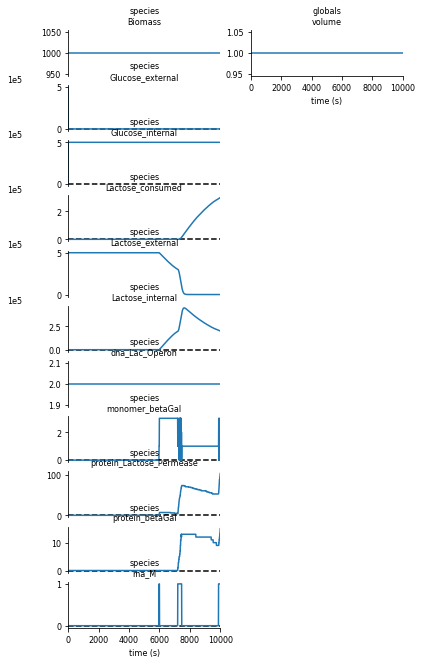

In [11]:
fig = plot_simulation_output(bioscrape_timeseries_stochastic)

## **Paradigm 3**: Multibody physics with pymunk
[pymunk](multibody) is an open-source video game physics engine.
[vivarium-multibody](https://github.com/vivarium-collective/vivarium-multibody) provides a Vivarium wrapper process for pymunk, configured specifically for multi-cellular physics:
 ```
 pip install vivarium-multibody
 ```

In [13]:
from vivarium_multibody.processes.multibody_physics import test_growth_division
from vivarium_multibody.processes.multibody_physics import agent_body_config, volume_from_length
from vivarium_multibody.plots.snapshots import (
    plot_snapshots,
    format_snapshot_data,
    make_snapshots_figure,
    get_field_range,
    get_agent_colors,
)
import numpy as np

from ipywidgets import interactive
import ipywidgets as widgets

In [14]:
total_time = 150
n_agents = 3
spatial_bounds = [70, 70]

# configure
agent_ids = [str(agent_id) for agent_id in range(n_agents)]
body_config = {'bounds': spatial_bounds, 'agent_ids': agent_ids}
multibody_config = {'bounds': spatial_bounds}
multibody_config.update(agent_body_config(body_config))

# experiment settings
experiment_settings = {'progress_bar': False, 'display_info': False}

# run multibody with grow/divide agents
multibody_data = test_growth_division(
        config=multibody_config,
        growth_rate=0.05,
        growth_rate_noise=0.05,
        division_volume=volume_from_length(4,1),
        total_time=total_time,
        experiment_settings=experiment_settings)
multibody_agents, multibody_fields = format_snapshot_data(multibody_data)

# make the snapshot plot function
time_vec = list(multibody_agents.keys()) 

# get fields and agent colors
multibody_field_range = get_field_range(multibody_fields, time_vec)
multibody_agent_colors = get_agent_colors(multibody_agents)

time_index_range = len(time_vec) -1

def plot_single_snapshot(t_index):   
    time_indices = np.array([t_index])
    snapshot_time = [time_vec[t_index]]
    fig = make_snapshots_figure(
        time_indices=time_indices,
        snapshot_times=snapshot_time,
        agents=multibody_agents,
        agent_colors=multibody_agent_colors,
        fields=multibody_fields,
        field_range=multibody_field_range,
        n_snapshots=1,
        bounds=spatial_bounds,
        default_font_size=12,
        plot_width=7)

In [15]:
interactive_plot = interactive(
    plot_single_snapshot, 
    t_index=widgets.IntSlider(min=0, max=time_index_range, step=2, value=0))

interactive_plot

interactive(children=(IntSlider(value=0, description='t_index', max=150, step=2), Output()), _dom_classes=('wi…

# BioscrapeCOBRA auxiliary processes 

* Connecting different Processes may require addition 'helper' Processes to make conversions and adapt their unique requirements different values.
* Derivers are a subclass of Process that runs after the other dynamic Processes and derives some states from others.

Included auxiliary processes:
* FluxDeriver
* BiomassAdaptor: this processes demonstrates vivarium units, and also the use of a Deriver as an adaptor between Processes

## Flux Deriver

A Deriver is a kind of Process which can be used to convert values of one store into another type of value in another store. For example, this FluxDeriver converts amounts of species and changes in amounts of species to instantaneous fluxes.

This FluxDeriver is used in the composite to convert the changes of Lactose and Glucose from the CRN model into flux-bounds for the FBA model. In these cases "deltas" (changes in Species) are converted to fluxes by dividing by the timestep.

This FluxDeriver is also used to convert changes in biomass, output from the FBA model, into a dilution rate constant used by the CRN. This flux is computered differently because the change in biomass each timestep is not stored. Additionally, dilution rate must be calculated as a percentage of the current amount, not absolute flux, and be non-negative.

In [16]:
class FluxDeriver(Process):
    """ Bioscrape delta species to fluxes for constraining COBRA """
    
    defaults = {
        'time_step':1.0,
        'flux_keys': {}, #key --> {option dictionary}
        'default_options' : { #default options if option_dictionary is empty
            "input_type":"delta", #"delta" corresponds to changes between timesteps. "amount" corresponds to the absolute quantity
        }
    }
    def __init__(self, config = None):
        super().__init__(config)
        
        self.prev_inputs = {k:None for k in self.parameters["flux_keys"]}

    def initial_state(self, config=None):
        return {}

    def ports_schema(self):
        return {
            'inputs': {
                flux_key: {
                    '_default': 0.0}
                for flux_key in self.parameters['flux_keys']
            },
            'fluxes': {
                flux_key: {
                    '_updater': 'set',
                    '_emit':True }
                for flux_key in self.parameters['flux_keys']
            }
        }
    
    def compute_flux(self, flux_key, dt, inputs):
        #computes the flux for a specific flux key of the time interval dt
        
        input_type = self.parameters['flux_keys'][flux_key].get("input_type", self.parameters['default_options']["input_type"])
        
        #Set delta
        if input_type == "delta":
            delta = inputs[flux_key]
        elif input_type == 'amount':
            if self.prev_inputs[flux_key] is None:
                delta = 0
            else:
                delta = inputs[flux_key]-self.prev_inputs[flux_key]
        else:
            raise ValueError(f"Unknown input_type: {input_type} for flux_key {flux_key}")
        
        return delta / dt
     
    def next_update(self, timestep, states):
        inputs = states["inputs"]
        
        update = {}
        update['fluxes'] = {}
        
        for flux_key in self.parameters['flux_keys']:
            #flux_dt = self.get_flux_interval(flux_key, timestep)
            #if flux_dt is not None:
            update['fluxes'][flux_key] = self.compute_flux(flux_key, timestep, inputs)
            
        self.prev_inputs = inputs
        return update

    
class DilutionFluxDeriver(FluxDeriver):
    #This is a non-negative "percentage" flux used to control a dilution rate of a CRN from a the rate of growth in biomass
    
    def next_update(self, timestep, states):        
        inputs = states["inputs"]
        
        update = {}
        update['fluxes'] = {}
        
        for flux_key in self.parameters['flux_keys']:
            flux = self.compute_flux(flux_key, timestep, inputs)

            #Convert to a percent of the previous input
            if self.prev_inputs[flux_key] is None or (self.prev_inputs[flux_key] == 0 and states["inputs"][flux_key] == 0):
                #Edge case: If both the current amount and the previous amount were 0, return 0
                update['fluxes'][flux_key] = 0

            elif self.prev_inputs[flux_key] == 0 and states["inputs"][flux_key] > 0:
                #Edge case: If both the previous amount was 0, us the current amount for the normalization
                update['fluxes'][flux_key] = flux/states["inputs"][flux_key]

            else:
                #Standard case
                update['fluxes'][flux_key] = flux/self.prev_inputs[flux_key]

            #Enforce non-negativity
            if update['fluxes'][flux_key] < 0 :
                update['fluxes'][flux_key] = 0

                
        self.prev_inputs = inputs
        return update

class AverageFluxDeriver(FluxDeriver):
    #This is similar to a FluxDeriver, but fluxes are averaged between updates. This is useful to compute fluxes 
    #which are used by a process with a larger dt than the processes controlling the flux, for example a stochastic
    #CRN may be updated frequently but FBA may be updated less frequently.
    pass

## BiomassAdaptor Deriver

This adaptor is used to do unit conversion between the mass output from cobra and a Species used in the Bioscrape model to represent biomass.

In [17]:
class mass_to_concentration(Deriver):
    """ Adapts COBRA mass variable to Bioscrape biomass """
    
    defaults = {
        'input_mass_units':1.0 * units.fg,
        'input_volume_units':1.0 * units.fL,
        'output_concentration_units':1.0 *units.mmolar,
        'characteristic_output_volume':1.0 *units.fL,
        'mass_species_molecular_weight':1.0 *units.fg/units.molec
    }
    
    def initial_state(self, config=None):
        return {}

    def ports_schema(self):
        return {
            'input': {
                'mass': {
                    '_default': 1.0 * self.parameters["input_mass_units"],
                },
                'volume': {
                    '_default': 1.0 * self.parameters["input_volume_units"]}
            },
            'output': {
                # the value used by Bioscrape
                'biomass': {
                    '_default': 1.0,
                    '_update': 'set',
                }
            }
        }


    def next_update(self, timestep, states):
        mass = states['input']['mass']
        
        # do conversion
        #Concentration = mass/molecular_weight/characteristic volume
        #Note: Biomass is also used to set Volume, so here we just set the scale
        mass_species_conc = mass/self.config['mass_species_molecular_weight']/(self.config['characteristic_output_volume'])        
    
        update = {
            'output': {
                #Return the correct units, with units stripped away for bioscrape
                'biomass': mass_species_conc.to(self.config['output_concentration_units']).magnitude
                }
            }
        return update

class mass_to_count(Deriver):
    """ Adapts COBRA mass variable to Bioscrape biomass """
    
    defaults = {
        'input_mass_units':1.0 * units.fg,
        'mass_species_molecular_weight':1.0 *units.fg/units.molec
    }
    
    def initial_state(self, config=None):
        return {}

    def ports_schema(self):
        return {
            'input': {
                'mass': {
                    '_default': 1.0 * units.fg,
                },
            },
            'output': {
                # the value used by Bioscrape
                'biomass': {
                    '_default': 1.0,
                    '_update': 'set',
                }
            }
        }


    def next_update(self, timestep, states):
        mass = states['input']['mass']
        
        # do conversion
        #count = mass/molecular_weight
        #Note: Biomass is also used to set Volume, so here we just set the scale
        mass_species_count = mass/self.config['mass_species_molecular_weight']        
    
        update = {
            'output': {
                #Return the correct units, with units stripped away for bioscrape
                'biomass': mass_species_count.magnitude
                }
            }
        return update

# BioscrapeCOBRA Composite

## BioscrapeCOBRA Composite configurations

This composite demonstrates advanced generate_topology() methods, which split ports across multiple stores with `'_path'`

TODO:
    * units for Biomass is in mmol/L of a species with mw of 1 fg/count = avagadro's number * fg / mol
    * import of Glucose is also in terms of 'Biomass' species
    * stochastically, it is in counts. Volume
    * logic for counts/concentrations if stochastic/deterministic
    * Bioscrape species 'Lactose_internal', 'Lactose_external' need to get wired to ('external',),
        But don't let Bioscrape update them. Only use FBA's resulting uptake.


In [18]:
#choose the SBML file and set other bioscrape parameters
deterministic_bioscrape_config = {
            'sbml_file': 'LacOperon_deterministic.xml',
            'stochastic': False,
            'initial_volume': 1,
            'internal_dt': 0.01,}

# set cobra constrained reactions config
cobra_config = get_iAF1260b_config()
cobra_config.update({'time_step': 10})

#set up the config for the FluxDeriver
flux_config = {
    'flux_keys': {
        'Lactose_consumed': {}, #No options specified
        'Glucose_internal': {}  #No options specified
    },
}

dilution_rate_flux_config = {
    'time_step':cobra_config['time_step'],
    'flux_keys': {
        'biomass':{
            "input_type":"amount"
        }
    }
}

#Here we override the default ports schema of the Biomass species and the k_dilution rate in Bioscrape.
#This is done so they can be set by the Derivers connected to mass and mass flux from Cobra.
schema_override = {
    'bioscrape': {
        'species': {
            'Biomass': { 
                '_updater': 'set'  #override bioscrape ('species', 'Biomass') with a 'set' updater
            }
        },
        'rates':{
            'k_dilution__':{
                '_emit':True, #k_dilution should be emitted so it can be plotted
                '_updater':'set'
            }
        }
    }
}

In [19]:
class BioscrapeCOBRA(Composite):

    defaults = {
        'bioscrape': deterministic_bioscrape_config,
        'cobra': cobra_config,
        'flux_deriver': flux_config,
        'dilution_rate_flux':dilution_rate_flux_config,
        'divide_on': False, # is division turned on?
        'agent_id': np.random.randint(0, 100),
        'divide_condition': {
            'threshold': 2000 * units.fg},
        'agents_path': ('..', '..', 'agents',),
        'daughter_path': tuple(),
         '_schema': schema_override,
        'stochastic':False
    }

    def generate_processes(self, config):
        processes = {
            'bioscrape': Bioscrape(config['bioscrape']),
            'cobra': DynamicFBA(config['cobra']),
            'mass_deriver': TreeMass(),
            'volume_deriver': Volume(),
        }
        
        #Process Logic for different kinds of simulations
        
        #Deterministic case
        if not config['bioscrape']['stochastic']:
            #deterministic simulations have a variable dilution rate
            processes['dilution_rate_adaptor'] = DilutionFluxDeriver(config["dilution_rate_flux"])
            
            #flux is computed as an instaneous flux
            processes['flux_deriver'] = FluxDeriver(config['flux_deriver'])
            
            #biomass is converted to a concentration
            processes['biomass_adaptor'] = mass_to_concentration()
        
        #Stochastic Case
        else:
            #flux is computed as an average flux
            processes['flux_deriver'] = AverageFluxDeriver(config['flux_deriver'])
            
            #biomass is converted to a molecular count
            processes['biomass_adaptor'] = mass_to_count()
        
        #Division Logic
        if config['divide_on']:
            # division config
            daughter_path = config['daughter_path']
            agent_id = config['agent_id']
            division_config = dict(
                config.get('division', {}),
                daughter_path=daughter_path,
                agent_id=agent_id,
                generator=self)

            processes.update({
                'divide_condition': DivideCondition(config['divide_condition']),
                'division': MetaDivision(division_config)
            })
        return processes

    def generate_topology(self, config):

        topology = {
            'bioscrape': {
                # all species go to a species store on the base level,
                # except Biomass, which goes to the 'globals' store, with variable 'biomass'
                'species': {
                    '_path': ('species',),
                    'Biomass': ('..', 'globals', 'biomass'),
                },
                'delta_species': ('delta_species',),
                'rates': {
                    '_path' : ('rates',),
                },
                'globals': ('globals',),
            },
            'cobra': {
                'internal_counts': ('internal_counts',),
                'external': ('external',),
                'exchanges': ('exchanges',),
                'reactions': ('reactions',),
                'flux_bounds': ('flux_bounds',),
                'global': ('globals',),
            },
            'flux_deriver': {
                'inputs': ('delta_species',),
                #'amounts': ('globals',),
                # connect Bioscrape deltas 'Lactose_consumed' and 'Glucose_internal'
                # to COBRA flux bounds 'EX_lac__D_e' and 'EX_glc__D_e'
                
                'fluxes':{
                        '_path': ('flux_bounds',),
                        'Lactose_consumed': ('EX_lac__D_e',),
                        'Glucose_internal': ('EX_glc__D_e',),
                    }
            },
            
            'mass_deriver': {
                'global': ('globals',),
            },
            'volume_deriver': {
                'global': ('globals',),
            },
            'biomass_adaptor': {
                'input': ('globals',),
                'output': ('globals',),
            }
        }
        
        #Ports added only in the deterministic case
        if not config['stochastic']:
            #Create port biomass flux to the dilution rate computed by the dilution_rate_adaptor process
            topology['dilution_rate_adaptor']= {
                'inputs':('globals',),
                'fluxes':{
                    '_path':('rates',),
                    'biomass':('k_dilution__',)
                }
            }
            
        #Ports added only in the stochastic case
        else:
            pass
        
        if config['divide_on']:
            agents_path = config['agents_path']

            # connect divide_condition to the mass variable
            topology.update({
                'divide_condition': {
                    'variable': ('globals', 'mass',),
                    'divide': ('globals', 'divide',),
                },
                'division': {
                    'global': ('globals',),
                    'agents': agents_path,
                },
            })
        return topology

In [20]:
bioscrape_cobra_composite = BioscrapeCOBRA({})

#experiment = compartment_in_experiment(bioscrape_cobra_composite)
#pp(experiment.state.get_config(True))



In [21]:
# get initial state
initial_state = bioscrape_cobra_composite.initial_state()
## override FBA default external state
initial_state['external']['glc__D_e'] = 10
initial_state['external']['lcts_e'] = 10
#TODO Bioscrape and Cobra's external state's should be linked up.

# simulate
settings = {
    'initial_state': initial_state,
    'total_time': 500}
bioscrape_cobra_output = simulate_compartment_in_experiment(
    bioscrape_cobra_composite, 
    settings)

#plt.figure()
#plt.plot(bioscrape_cobra_output['time'], bioscrape_cobra_output['rates']['k_dilution__'])


Experiment ID: d6134ae2-670d-11eb-8fe3-acde48001122
Created: 02/04/2021 at 09:24:28


/Users/eranagmon/.pyenv/versions/3.8.3/envs/notebooks/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


Completed in 13.06 seconds


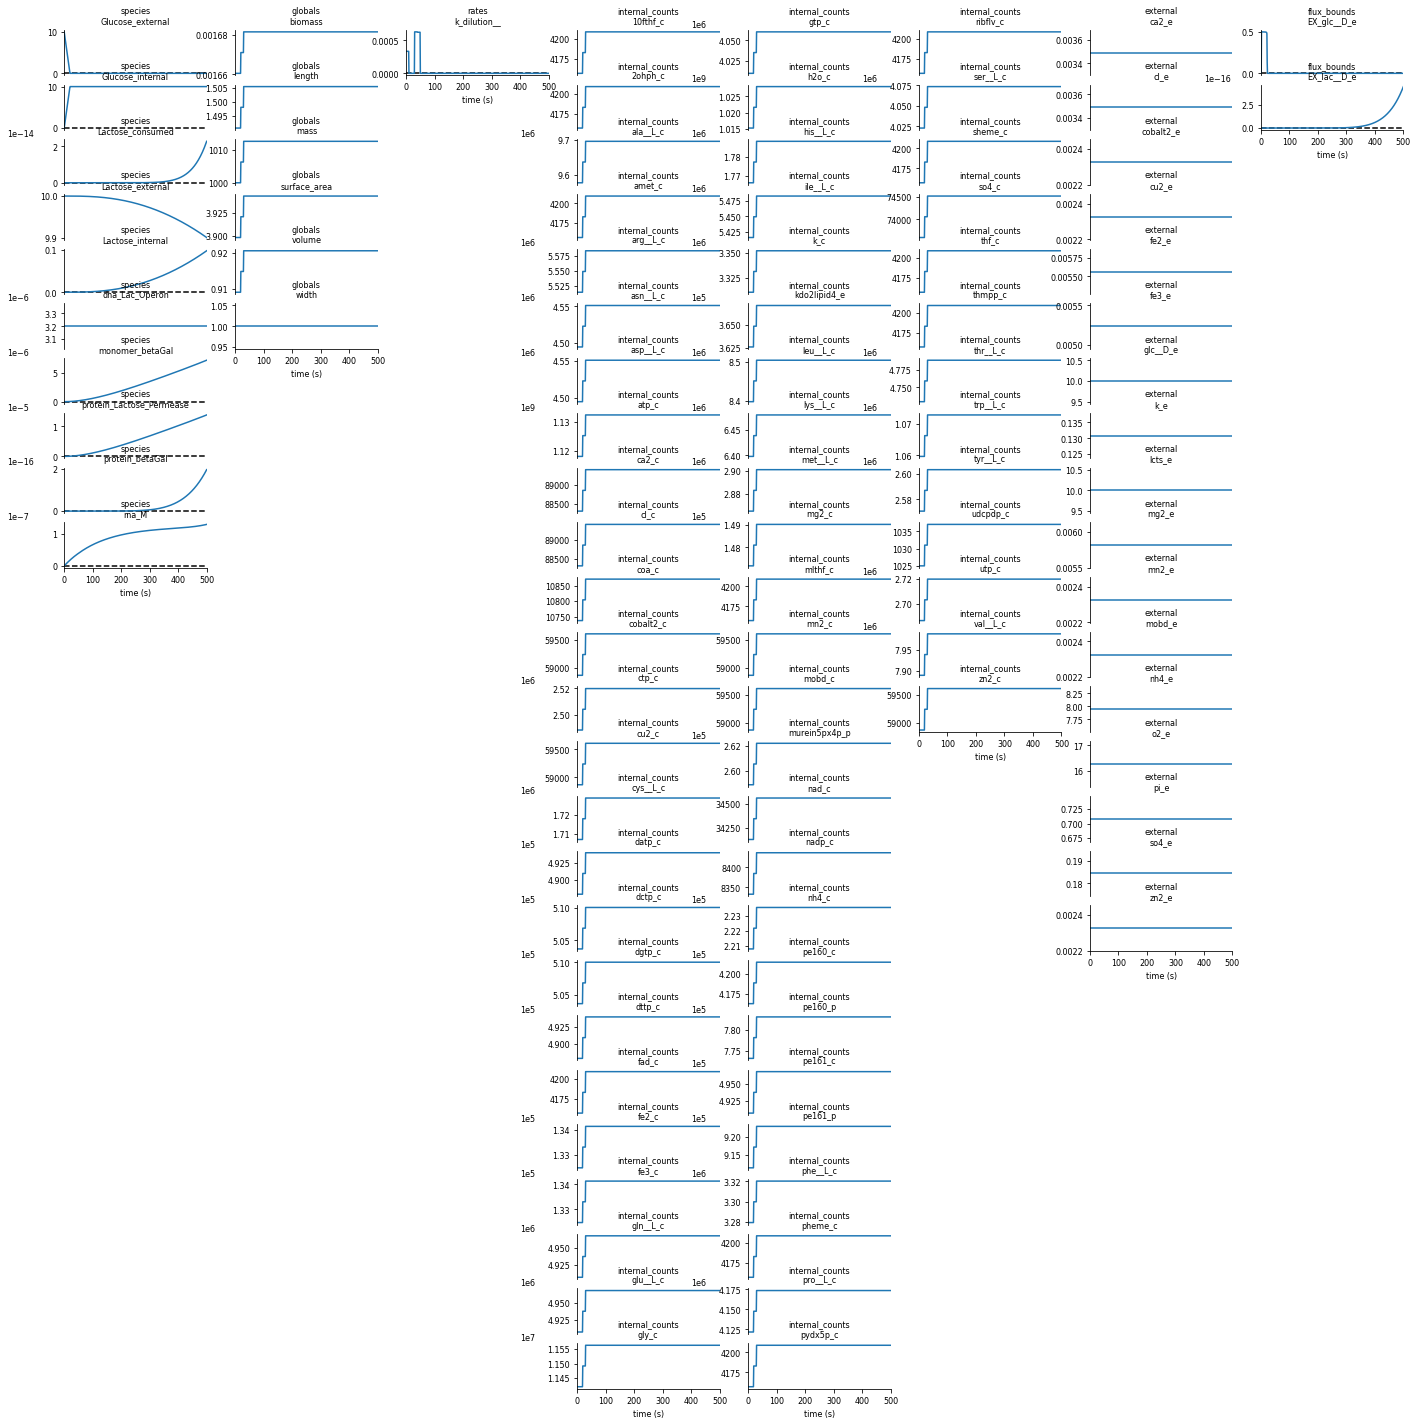

In [22]:
fig = plot_simulation_output(bioscrape_cobra_output)

## Stochastic Bioscrape-Cobra

Changes required for Stochastic Model
* New CRN Model without dilution and with initial conditions in counts instead of concentration
    * this means "k_dilution__" porting needs to removed from the topology
* BiomassDeriver converts to counts instead of concentration
* FluxDeriver run in "stochastic" mode where flux is averaged over the cobra update time-frame.

In [23]:
stochastic_bioscrape_config = {
            'sbml_file': 'LacOperon_stochastic.xml',
            'stochastic': True,
            'initial_volume': 1,
            'internal_dt': 0.01,}

bioscrape_cobra_composite_stochastic = BioscrapeCOBRA({"bioscrape":stochastic_bioscrape_config})
# get initial state
initial_state = bioscrape_cobra_composite_stochastic.initial_state()
## override FBA default external state
initial_state['external']['glc__D_e'] = 10**6
initial_state['external']['lcts_e'] = 10**6

# simulate
settings = {
    'initial_state': initial_state,
    'total_time': 1000}
bioscrape_cobra_output_stochastic = simulate_compartment_in_experiment(
    bioscrape_cobra_composite_stochastic, 
    settings)


Experiment ID: e5d45714-670d-11eb-8fe3-acde48001122
Created: 02/04/2021 at 09:24:55
states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 500000.0, 'Lactose_internal': 0.0, 'Glucose_external': 500000.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, '

/Users/eranagmon/.pyenv/versions/3.8.3/envs/notebooks/lib/python3.8/site-packages/vivarium_bioscrape/processes/bioscrape.py:156: UserWarning: Trying to set parameter that is not in model: k_dilution__
  self.model.set_params(states['rates'])
/Users/eranagmon/.pyenv/versions/3.8.3/envs/notebooks/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


took 0.1690020000000061
states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 500000.0, 'Lactose_internal': 0.0, 'Glucose_external': 210134.0, 'Glucose_internal': 289866.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': -289866.0, 'Glucose_internal': 289866.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 500000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G'

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 500000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G'

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 500000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G'

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 500000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G'

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 500000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G'

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 500000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G'

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 500000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G'

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 500000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G'

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 500000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G'

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 500000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G'

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 500000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G'

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 500000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G'

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 500000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G'

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 500000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G'

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 500000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G'

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 500000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G'

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 500000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G'

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 500000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G'

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 500000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G'

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 500000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G'

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 500000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G'

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 500000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G'

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 500000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G'

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 500000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G'

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 500000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G'

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 500000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G'

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 500000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G'

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 500000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G'

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 500000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G'

took 0.0005919999999974834
states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 500000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 500000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G'

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 500000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G'

states {'species': {'rna_M': 1.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 500000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 1.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G'

states {'species': {'rna_M': 1.0, 'monomer_betaGal': 2.0, 'protein_betaGal': 0.0, 'Lactose_external': 499623.0, 'Lactose_internal': 377.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 3.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -74.0, 'Lactose_internal': 74.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 1.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 2.0, 'protein_betaGal': 0.0, 'Lactose_external': 498546.0, 'Lactose_internal': 1454.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 4.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -113.0, 'Lactose_internal': 113.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 2.0, 'protein_betaGal': 0.0, 'Lactose_external': 497537.0, 'Lactose_internal': 2463.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 4.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -87.0, 'Lactose_internal': 87.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0,

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 2.0, 'protein_betaGal': 0.0, 'Lactose_external': 496448.0, 'Lactose_internal': 3552.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 4.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -96.0, 'Lactose_internal': 96.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0,

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 2.0, 'protein_betaGal': 0.0, 'Lactose_external': 495320.0, 'Lactose_internal': 4680.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 4.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -133.0, 'Lactose_internal': 133.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 2.0, 'protein_betaGal': 0.0, 'Lactose_external': 494255.0, 'Lactose_internal': 5745.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 4.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -99.0, 'Lactose_internal': 99.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0,

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 2.0, 'protein_betaGal': 0.0, 'Lactose_external': 493161.0, 'Lactose_internal': 6839.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 4.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -103.0, 'Lactose_internal': 103.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 2.0, 'protein_betaGal': 0.0, 'Lactose_external': 492092.0, 'Lactose_internal': 7908.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 4.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -95.0, 'Lactose_internal': 95.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0,

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 2.0, 'protein_betaGal': 0.0, 'Lactose_external': 491057.0, 'Lactose_internal': 8943.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 4.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -105.0, 'Lactose_internal': 105.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 2.0, 'protein_betaGal': 0.0, 'Lactose_external': 490023.0, 'Lactose_internal': 9977.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 4.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -97.0, 'Lactose_internal': 97.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0,

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 2.0, 'protein_betaGal': 0.0, 'Lactose_external': 488902.0, 'Lactose_internal': 11098.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 4.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -94.0, 'Lactose_internal': 94.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 2.0, 'protein_betaGal': 0.0, 'Lactose_external': 487843.0, 'Lactose_internal': 12157.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 4.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -118.0, 'Lactose_internal': 118.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 2.0, 'protein_betaGal': 0.0, 'Lactose_external': 486788.0, 'Lactose_internal': 13212.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 4.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -115.0, 'Lactose_internal': 115.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 2.0, 'protein_betaGal': 0.0, 'Lactose_external': 485766.0, 'Lactose_internal': 14234.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 4.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -95.0, 'Lactose_internal': 95.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 2.0, 'protein_betaGal': 0.0, 'Lactose_external': 484643.0, 'Lactose_internal': 15357.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 4.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -124.0, 'Lactose_internal': 124.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 2.0, 'protein_betaGal': 0.0, 'Lactose_external': 483628.0, 'Lactose_internal': 16372.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 4.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -99.0, 'Lactose_internal': 99.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 2.0, 'protein_betaGal': 0.0, 'Lactose_external': 482532.0, 'Lactose_internal': 17468.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 4.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -82.0, 'Lactose_internal': 82.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0

states {'species': {'rna_M': 1.0, 'monomer_betaGal': 3.0, 'protein_betaGal': 0.0, 'Lactose_external': 481419.0, 'Lactose_internal': 18581.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 5.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 1.0, 'protein_betaGal': 0.0, 'Lactose_external': -155.0, 'Lactose_internal': 155.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000

states {'species': {'rna_M': 1.0, 'monomer_betaGal': 3.0, 'protein_betaGal': 1.0, 'Lactose_external': 479525.0, 'Lactose_internal': 20467.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 8.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 8.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -210.0, 'Lactose_internal': 210.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000

states {'species': {'rna_M': 1.0, 'monomer_betaGal': 1.0, 'protein_betaGal': 2.0, 'Lactose_external': 476387.0, 'Lactose_internal': 23595.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 14.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 18.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 1.0, 'protein_betaGal': 0.0, 'Lactose_external': -379.0, 'Lactose_internal': 377.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 2.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 29000

states {'species': {'rna_M': 1.0, 'monomer_betaGal': 2.0, 'protein_betaGal': 2.0, 'Lactose_external': 470980.0, 'Lactose_internal': 28980.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 19.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1003.2777581055041, 'Lactose_consumed': 40.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -500.0, 'Lactose_internal': 498.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 2.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900

states {'species': {'rna_M': 1.0, 'monomer_betaGal': 3.0, 'protein_betaGal': 2.0, 'Lactose_external': 463954.0, 'Lactose_internal': 35978.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 22.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1007.8641365999221, 'Lactose_consumed': 68.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -562.0, 'Lactose_internal': 560.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 2.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900

states {'species': {'rna_M': 1.0, 'monomer_betaGal': 2.0, 'protein_betaGal': 3.0, 'Lactose_external': 455522.0, 'Lactose_internal': 44356.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 28.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1012.4714802559605, 'Lactose_consumed': 122.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -723.0, 'Lactose_internal': 717.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 6.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 290

states {'species': {'rna_M': 1.0, 'monomer_betaGal': 2.0, 'protein_betaGal': 4.0, 'Lactose_external': 446136.0, 'Lactose_internal': 53662.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 32.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1023.3283776977647, 'Lactose_consumed': 202.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -820.0, 'Lactose_internal': 812.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 8.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 290

took 0.0010019999999997253
states {'species': {'rna_M': 1.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 5.0, 'Lactose_external': 436383.0, 'Lactose_internal': 63305.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 36.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1028.8004786827778, 'Lactose_consumed': 312.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -948.0, 'Lactose_internal': 935.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 13.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 5.0, 'Lactose_external': 426998.0, 'Lactose_internal': 72566.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 36.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1035.4993189306547, 'Lactose_consumed': 436.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -909.0, 'Lactose_internal': 897.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 12.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 29

took 0.0009579999999971278
states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 5.0, 'Lactose_external': 415779.0, 'Lactose_internal': 83604.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 36.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1044.6523403543852, 'Lactose_consumed': 617.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -935.0, 'Lactose_internal': 920.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 15.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 5.0, 'Lactose_external': 405583.0, 'Lactose_internal': 93643.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 36.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1055.102193389138, 'Lactose_consumed': 774.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -933.0, 'Lactose_internal': 920.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 13.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 290

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 5.0, 'Lactose_external': 395531.0, 'Lactose_internal': 103466.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 36.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1068.5221212003014, 'Lactose_consumed': 1003.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -1006.0, 'Lactose_internal': 985.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 21.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L':

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 5.0, 'Lactose_external': 384533.0, 'Lactose_internal': 114245.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 36.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1079.2107448024399, 'Lactose_consumed': 1222.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -889.0, 'Lactose_internal': 867.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 22.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 5.0, 'Lactose_external': 372596.0, 'Lactose_internal': 125903.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 36.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1105.1403571585752, 'Lactose_consumed': 1501.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -961.0, 'Lactose_internal': 940.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 21.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 5.0, 'Lactose_external': 361106.0, 'Lactose_internal': 137073.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 36.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1117.9103984403541, 'Lactose_consumed': 1821.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -954.0, 'Lactose_internal': 930.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 24.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 5.0, 'Lactose_external': 350434.0, 'Lactose_internal': 147426.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 36.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1128.6593310956266, 'Lactose_consumed': 2140.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -859.0, 'Lactose_internal': 828.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 31.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 5.0, 'Lactose_external': 338798.0, 'Lactose_internal': 158754.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 36.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1143.4527453255023, 'Lactose_consumed': 2448.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -905.0, 'Lactose_internal': 891.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 14.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 5.0, 'Lactose_external': 329264.0, 'Lactose_internal': 167952.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 36.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1168.2322154563672, 'Lactose_consumed': 2784.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -852.0, 'Lactose_internal': 813.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 39.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 5.0, 'Lactose_external': 319906.0, 'Lactose_internal': 176991.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 36.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1186.263857531283, 'Lactose_consumed': 3103.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -857.0, 'Lactose_internal': 832.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 25.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 5.0, 'Lactose_external': 308825.0, 'Lactose_internal': 187681.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 36.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1200.431539653285, 'Lactose_consumed': 3494.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -861.0, 'Lactose_internal': 820.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 41.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 5.0, 'Lactose_external': 297971.0, 'Lactose_internal': 198147.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 36.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1217.097182156776, 'Lactose_consumed': 3882.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -873.0, 'Lactose_internal': 846.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 27.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 5.0, 'Lactose_external': 287030.0, 'Lactose_internal': 208650.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 36.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1253.0399599430252, 'Lactose_consumed': 4320.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -823.0, 'Lactose_internal': 782.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 41.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 5.0, 'Lactose_external': 278064.0, 'Lactose_internal': 217257.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 36.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1273.3529304290032, 'Lactose_consumed': 4679.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -830.0, 'Lactose_internal': 794.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 36.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 5.0, 'Lactose_external': 266611.0, 'Lactose_internal': 228182.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 36.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1293.9951931953053, 'Lactose_consumed': 5207.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -766.0, 'Lactose_internal': 730.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 36.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 5.0, 'Lactose_external': 256932.0, 'Lactose_internal': 237407.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 36.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1317.9843936915363, 'Lactose_consumed': 5661.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -768.0, 'Lactose_internal': 734.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 34.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 5.0, 'Lactose_external': 246570.0, 'Lactose_internal': 247281.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 36.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1363.6605650156025, 'Lactose_consumed': 6149.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -808.0, 'Lactose_internal': 766.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 42.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 5.0, 'Lactose_external': 238093.0, 'Lactose_internal': 255284.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 36.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1385.766801823562, 'Lactose_consumed': 6623.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -786.0, 'Lactose_internal': 750.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 36.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 5.0, 'Lactose_external': 231327.0, 'Lactose_internal': 261652.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 36.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1411.4573457606562, 'Lactose_consumed': 7021.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -752.0, 'Lactose_internal': 711.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 41.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 5.0, 'Lactose_external': 222895.0, 'Lactose_internal': 269658.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 36.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1442.5527887719597, 'Lactose_consumed': 7447.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -762.0, 'Lactose_internal': 708.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 54.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 5.0, 'Lactose_external': 213205.0, 'Lactose_internal': 278803.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 36.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1469.8557693340183, 'Lactose_consumed': 7992.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -744.0, 'Lactose_internal': 692.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 52.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 5.0, 'Lactose_external': 203729.0, 'Lactose_internal': 287695.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 36.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1492.5429750104838, 'Lactose_consumed': 8576.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -704.0, 'Lactose_internal': 671.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 33.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 5.0, 'Lactose_external': 194456.0, 'Lactose_internal': 296383.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 36.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1557.846669904523, 'Lactose_consumed': 9161.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -699.0, 'Lactose_internal': 641.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 58.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 5.0, 'Lactose_external': 186749.0, 'Lactose_internal': 303621.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 36.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1591.5627622739082, 'Lactose_consumed': 9630.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -752.0, 'Lactose_internal': 714.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 38.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 5.0, 'Lactose_external': 178533.0, 'Lactose_internal': 311332.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 36.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1630.94858005682, 'Lactose_consumed': 10135.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -655.0, 'Lactose_internal': 607.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 48.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 5.0, 'Lactose_external': 169696.0, 'Lactose_internal': 319613.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 36.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1656.1222478301875, 'Lactose_consumed': 10691.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -648.0, 'Lactose_internal': 597.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 51.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L':

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 5.0, 'Lactose_external': 160418.0, 'Lactose_internal': 328230.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 36.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1722.0254731018747, 'Lactose_consumed': 11352.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -616.0, 'Lactose_internal': 557.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 59.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L':

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 5.0, 'Lactose_external': 153375.0, 'Lactose_internal': 334759.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 36.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1761.9673298049302, 'Lactose_consumed': 11866.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -655.0, 'Lactose_internal': 610.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 45.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L':

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 5.0, 'Lactose_external': 145188.0, 'Lactose_internal': 342316.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 35.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1795.999448220425, 'Lactose_consumed': 12496.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -561.0, 'Lactose_internal': 500.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 61.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 5.0, 'Lactose_external': 138130.0, 'Lactose_internal': 348771.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 35.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1841.1412095238325, 'Lactose_consumed': 13099.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -615.0, 'Lactose_internal': 565.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 50.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L':

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 5.0, 'Lactose_external': 130895.0, 'Lactose_internal': 355339.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 34.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1883.1315799347901, 'Lactose_consumed': 13766.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -520.0, 'Lactose_internal': 464.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 56.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L':

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 5.0, 'Lactose_external': 124331.0, 'Lactose_internal': 361276.0, 'Glucose_external': 0.0, 'Glucose_internal': 500000.0, 'protein_Lactose_Permease': 34.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1975.239893258083, 'Lactose_consumed': 14393.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -569.0, 'Lactose_internal': 527.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 42.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 

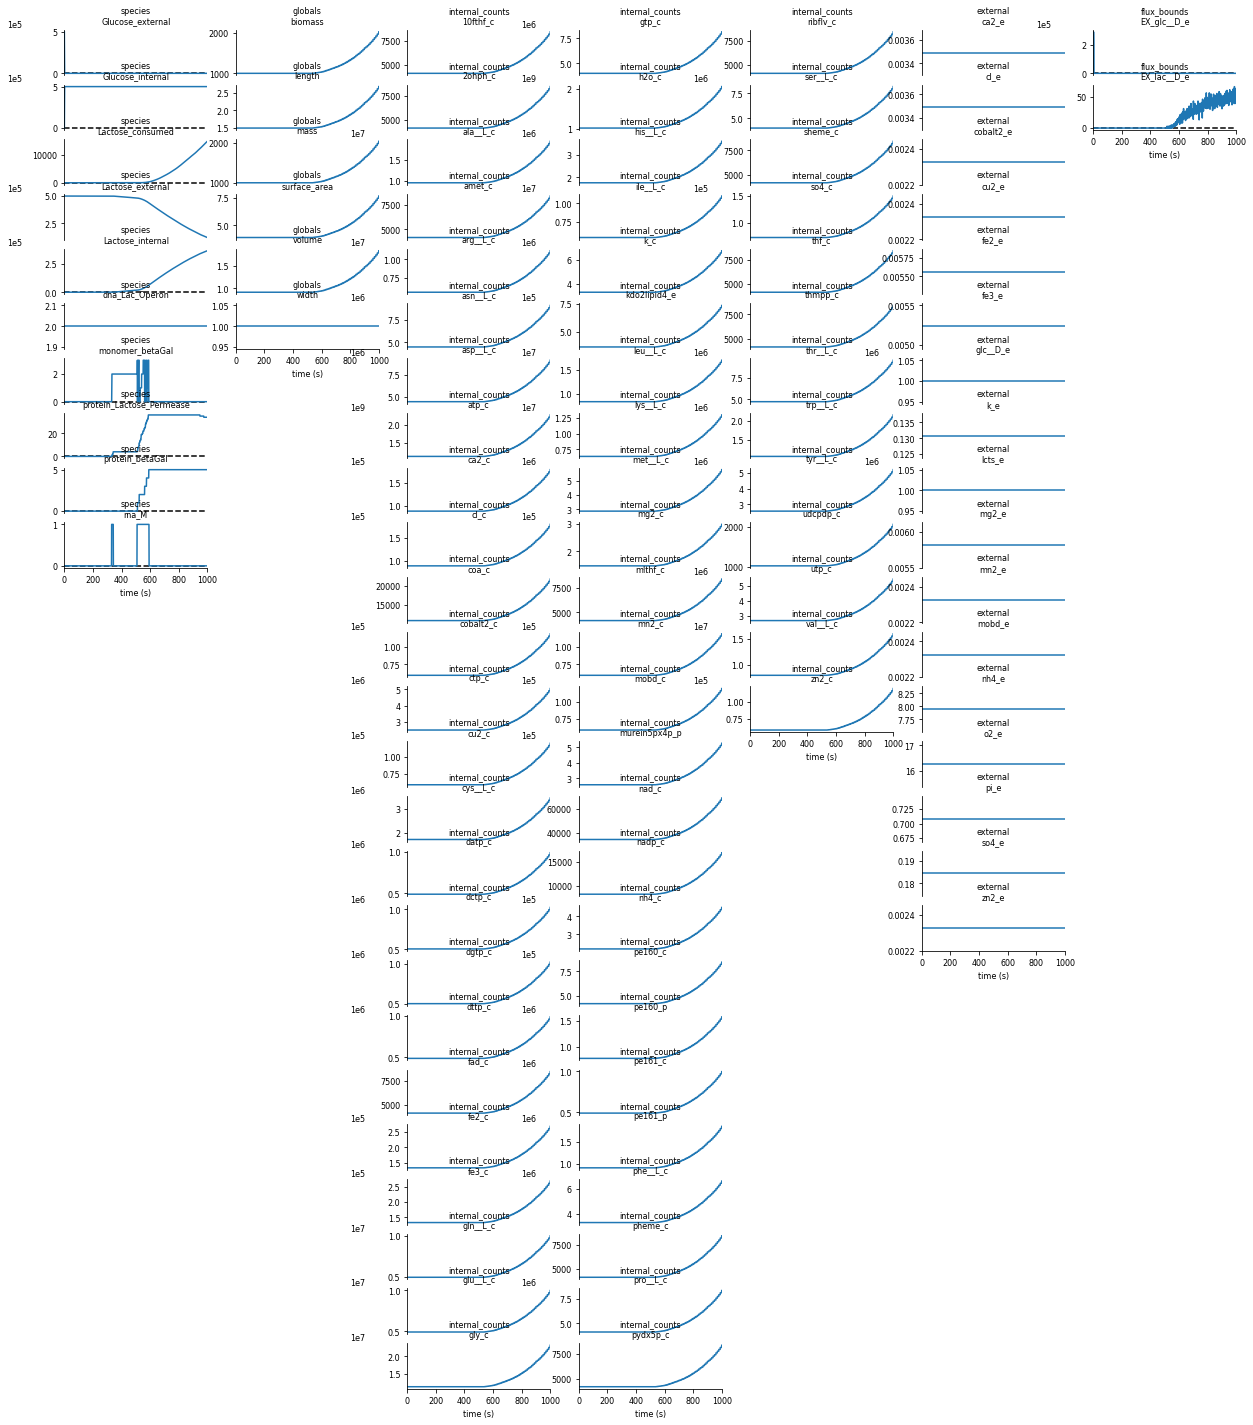

In [24]:
fig = plot_simulation_output(bioscrape_cobra_output_stochastic)

## Turning on Division

In [25]:
total_time = 2500

agent_id = '1'
division_config = {
    'divide_on': True,
    'agent_id': agent_id,
    'agents_path': ('..', '..', 'agents',),
}
division_composite = BioscrapeCOBRA(division_config)

# initial state
initial_state = division_composite.initial_state()
# initial_state['species']['Glucose_external'] = 2000
initial_state['external']['glc__D_e'] = 10
initial_state['external']['lcts_e'] = 10
initial_state = {
    'agents': {
        agent_id: initial_state}}

# run simulation
# simulate
settings = {
    'outer_path': ('agents', agent_id,),
    'initial_state': initial_state,
    'experiment_id': 'division'}
division_experiment = compartment_in_experiment(
    division_composite,
    settings=settings,
    initial_state=initial_state)




Experiment ID: division
Created: 02/04/2021 at 09:25:31


In [26]:
# run the experiment and extract the data
division_experiment.update(total_time)
division_output = division_experiment.emitter.get_data_unitless()

/Users/eranagmon/.pyenv/versions/3.8.3/envs/notebooks/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


Completed in 61.81 seconds


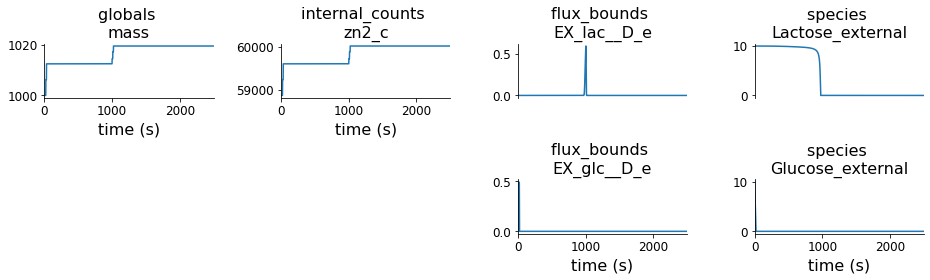

In [27]:
plot_settings = {
#     'skip_paths': [('external',)]
    'include_paths': [
        ('globals', 'mass'),
        ('species', 'Glucose_external'),
        ('species', 'Lactose_external'),
        ('flux_bounds', 'EX_glc__D_e'),
        ('flux_bounds', 'EX_lac__D_e'),
        ('internal_counts', 'zn2_c'),
        ],
}
fig = plot_agents_multigen(
    division_output,
    settings=plot_settings,
)

# Simulate BioscrapeCOBRA in a Spatial Environment
 * We here plug BioscrapeCOBRA into an environmental composite called Lattice, which has a multi-body physics process (MBP) and a spatial diffusion process (DFF).

In [28]:
from vivarium_multibody.composites.lattice import Lattice, make_lattice_config

# declare configurations
agent_id = '1'
lattice_bounds = [20, 20]
env_config = {
    'time_step': 60,
    'bounds': lattice_bounds}

# declare the hierarchy
hierarchy = {
    FACTORY_KEY: {
        'type': Lattice,
        'config': make_lattice_config()},
    'agents': {
        agent_id: {
            FACTORY_KEY: {
                'type': BioscrapeCOBRA,
                'config': {
                    'divide_on': True,
                    'agent_id': agent_id,
                    'agents_path': ('..', '..', 'agents',),
                }}}}}


# configure experiment with helper function compose_experiment()
initial_state = division_composite.initial_state()
# initial_state['species']['Glucose_external'] = 2000
initial_state['external']['glc__D_e'] = 10
initial_state['external']['lcts_e'] = 10
initial_state = {
    'agents': {
        agent_id: initial_state}}

experiment_settings = {
    'initial_state': initial_state,
    'experiment_id': 'spatial_environment'}

In [29]:
# make the experiment
spatial_experiment = compose_experiment(
    hierarchy=hierarchy, 
    settings=experiment_settings)

# run the experiment
spatial_experiment.update(1000)

# retrieve the data
spatial_data = spatial_experiment.emitter.get_data_unitless()
agents, fields = format_snapshot_data(spatial_data)


Experiment ID: spatial_environment
Created: 02/04/2021 at 09:26:41


/Users/eranagmon/.pyenv/versions/3.8.3/envs/notebooks/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


Completed in 25.18 seconds


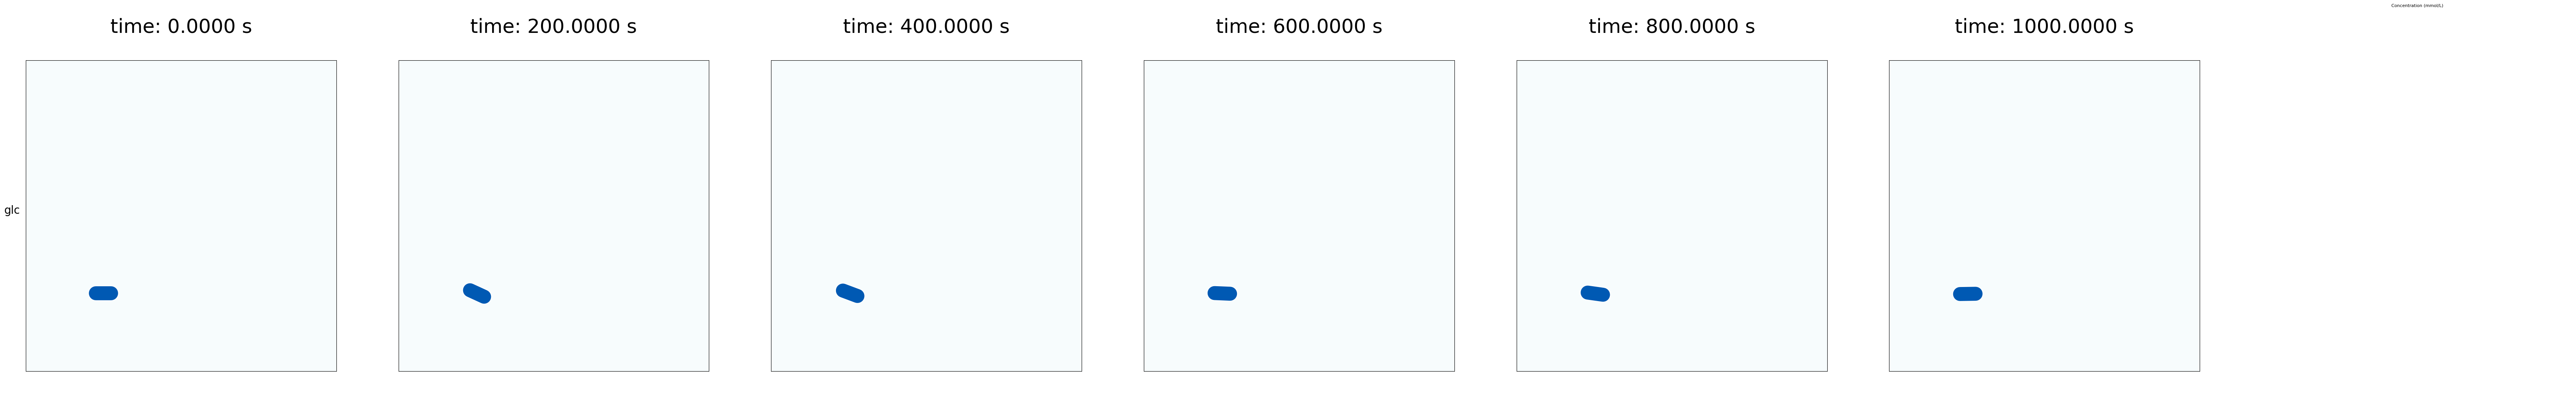

In [30]:
fig = plot_snapshots(
    bounds=lattice_bounds, 
    agents=agents, 
    fields=fields)